In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [ ]:
# Для создания теста было взято 10% картинок каждого класса из train и сохранено в папку test_new
# Это не лучший способ разделения данных, тут используется для простоты

import random
import shutil

def create_test_set_from_train(root_dir, selected_classes, test_percentage=0.1):
    

    train_dir = os.path.join(root_dir, 'train')
    test_new_dir = os.path.join(root_dir, 'test_new', 'images')
    
    # Создаем основную папку test_new/images если её нет
    os.makedirs(test_new_dir, exist_ok=True)
    
    # Счетчики для статистики
    total_moved = 0
    
    print(f"Создание тестового набора из {test_percentage*100}% train данных...")
    
    for cls in selected_classes:
        cls_train_dir = os.path.join(train_dir, cls, 'images')
        
        # Получаем все изображения из папки класса
        all_images = [img for img in os.listdir(cls_train_dir) 
                     if img.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        
        num_to_move = max(1, int(len(all_images) * test_percentage))
        
        # Случайно выбираем изображения для перемещения
        images_to_move = random.sample(all_images, min(num_to_move, len(all_images)))
        
        # Создаем папку класса в test_new
        cls_test_dir = os.path.join(test_new_dir, cls)
        os.makedirs(cls_test_dir, exist_ok=True)
        
        for img_name in images_to_move:
            src_path = os.path.join(cls_train_dir, img_name)
            dst_path = os.path.join(cls_test_dir, img_name)
            
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)  # Перемещаем файл
                total_moved += 1
        
        print(f"Класс {cls}: перемещено {len(images_to_move)} из {len(all_images)} изображений")
    

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, selected_classes=None):

        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.all_class_names = [line.strip() for line in f]
        
        # Определяем, какие классы использовать
        if selected_classes is None:
            # Берем первые 10 классов, если не указаны конкретные
            self.class_names = self.all_class_names[:10]
        else:
            self.class_names = selected_classes[:10]  # Берем не более 10 классов
        
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        
        self.samples = []
        
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in self.class_names:  # Только выбранные классы
                cls_dir = os.path.join(train_dir, cls)
                if not os.path.exists(cls_dir):
                    continue
                    
                img_dir = os.path.join(cls_dir, 'images')
                if not os.path.exists(img_dir):
                    continue
                    
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))
                    
        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls and cls in self.class_to_idx:  # Только выбранные классы
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'test':
            # Путь для созданной тестовой выборки
            test_new_dir = os.path.join(root_dir, 'test_new', 'images')
            
            for cls in self.class_names:  # Только выбранные классы
                cls_dir = os.path.join(test_new_dir, cls)
                if not os.path.exists(cls_dir):
                    continue
                
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                        img_path = os.path.join(cls_dir, img_name)
                        label = self.class_to_idx[cls]
                        self.samples.append((img_path, label))
                    

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((72, 72)),                    
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "./data/tiny-imagenet-200 1/tiny-imagenet-200"

# Выбранные классы
selected = [
    'n02279972', #monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
    'n01774384', #black widow, Latrodectus mactans
    'n01945685', #slug
    'n02190166', #fly
    'n01774750', #tarantula
    'n01784675', #centipede
    'n01944390', #snail
    'n02165456', #ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
    'n02206856', #bee
    'n02226429', #grasshopper, hopper
]

#create_test_set_from_train(root, selected, test_percentage=0.1)

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform, selected_classes=selected)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform, selected_classes=selected)
test_dataset = TinyImageNetDataset(root, split='test', transform=val_transform, selected_classes=selected)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Всего классов: {len(train_dataset.class_names)}")

Train size: 4500
Val size: 500
Test size: 500
Всего классов: 10


In [6]:
# 2.1. Реализация Basic Block

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        super(BasicBlock, self).__init__()
        
        # Первая сверточная часть блока
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Вторая сверточная часть блока
        self.conv2 = nn.Conv2d( in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # ReLU активация
        self.relu = nn.ReLU(inplace=True)
        
        # Downsample в skip connection если нужно
        self.downsample = downsample

        self.stride = stride
        
    def forward(self, x):
        # Сохраняем для skip connection
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out


def make_block(in_channels, out_channels, stride=1):

    downsample = None
    # Если размерности не совпадают
    if stride != 1 or in_channels != out_channels:
        downsample = nn.Sequential(
            nn.Conv2d( in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels))
    return BasicBlock( in_channels=in_channels, out_channels=out_channels, stride=stride, downsample=downsample)



# тест 1: без downsample
print("Тест 1")
b1 = make_block(64, 64, 1)
x1 = torch.randn(4,64,32,32)
print(f"вход: {x1.shape}")
print(f"выход: {b1(x1).shape}")
print()

# тест 2: каналы меняются
print("Тест 2")
b2 = make_block(64, 128, 1)
x2 = torch.randn(4,64,32,32)
print(f"вход: {x2.shape}")
print(f"выход: {b2(x2).shape}")
print()

# тест 3: stride=2
print("Тест 3")
b3 = make_block(64, 128, 2)
x3 = torch.randn(4,64,32,32)
print(f"вход: {x3.shape}")
print(f"выход: {b3(x3).shape}")
print()

# тест 4: всё меняется
print("Тест 4")
b4 = make_block(64, 256, 2)
x4 = torch.randn(4,64,64,64)
print(f"вход: {x4.shape}")
print(f"выход: {b4(x4).shape}")

#print(block1)

Тест 1
вход: torch.Size([4, 64, 32, 32])
выход: torch.Size([4, 64, 32, 32])

Тест 2
вход: torch.Size([4, 64, 32, 32])
выход: torch.Size([4, 128, 32, 32])

Тест 3
вход: torch.Size([4, 64, 32, 32])
выход: torch.Size([4, 128, 16, 16])

Тест 4
вход: torch.Size([4, 64, 64, 64])
выход: torch.Size([4, 256, 32, 32])


In [7]:
# 2.2. Реализация ResNet18
    
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = nn.Sequential(
            make_block(64, 64, stride=1),
            make_block(64, 64, stride=1)
        )
        
        self.layer2 = nn.Sequential(
            make_block(64, 128, stride=2),
            make_block(128, 128, stride=1)
        )
        
        self.layer3 = nn.Sequential(
            make_block(128, 256, stride=2),
            make_block(256, 256, stride=1)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


# Проверка на случайном тензоре
test_input = torch.randn(4, 3, 64, 64)  # батч из 4 картинок 64x64

model = ResNet18(num_classes=10)
output = model(test_input)
print(f"\nвход: {test_input.shape}")
print(f"выход: {output.shape}")


вход: torch.Size([4, 3, 64, 64])
выход: torch.Size([4, 10])


In [10]:
# 2.4. Скрипт обучения

# Функции для обучения
def train_epoch(model, loader, criterion, optimizer, device):
    model.train() # Переводим модель в режим обучения
    running_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    loss_avg = running_loss / len(loader)
    acc = 100. * correct / total
    return loss_avg, acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Пропускаем loss если метки отсутствуют (все -1)
            if labels[0] != -1: 
                labels = labels.to(device)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

    if total > 0:
        loss_avg = running_loss / len(loader)
        acc = 100. * correct / total
    else:
        loss_avg = 0
        acc = 0

    return loss_avg, acc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = ResNet18(num_classes=10).to(device)

# Проверяем параметры
total_params = sum(p.numel() for p in model.parameters())
print(f"Параметры: {total_params:,}")

max_channels = 0
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        max_channels = max(max_channels, m.out_channels)
print(f"Макс каналы: {max_channels}")
print()

# Настройки обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # или SGD

# Обучение
num_epochs = 20

# Сохраняем историю
train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_acc = 0
start_time = time.time()

for epoch in range(num_epochs):
    #print(f"\nЭпоха {epoch+1}")
    
    # Обучаем
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Проверяем
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Выводим результаты
    print(f"{epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Сохраняем лучшую модель
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'model.pth')
        #print(f"Acc лучшей модели: {val_acc:.2f}%")

# Результаты
total_time = time.time() - start_time
print(f"\nОбучение завершено")
print(f"Время: {total_time:.0f} сек")
print(f"Лучшая точность: {best_acc:.2f}%")
print(f"Финальная точность: {val_accs[-1]:.2f}%")

# Сохраняем последнюю модель
torch.save(model.state_dict(), 'last_model.pth')

"""
# Проверяем на тесте
print("\nТестирование")
test_dataset = TinyImageNetDataset(root, split='test', transform=val_transform, selected_classes=selected)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc: {test_acc:.2f}%")
"""

"""
# Итоги
print("\nИтоги")
print(f"Train Acc: {train_accs[-1]:.2f}%")
print(f"Val Acc: {val_accs[-1]:.2f}%")
print(f"Всего параметров: {total_params:,}")
"""

Device: cpu
Параметры: 2,777,674
Макс каналы: 256

1 | Train Loss: 2.2163 | Train Acc: 19.58% | Val Loss: 2.1211 | Val Acc: 24.20%
2 | Train Loss: 2.1325 | Train Acc: 22.46% | Val Loss: 2.1240 | Val Acc: 26.40%
3 | Train Loss: 2.0931 | Train Acc: 24.80% | Val Loss: 2.3075 | Val Acc: 20.80%
4 | Train Loss: 2.0468 | Train Acc: 26.28% | Val Loss: 2.3548 | Val Acc: 24.00%
5 | Train Loss: 1.9858 | Train Acc: 29.48% | Val Loss: 2.9987 | Val Acc: 25.40%
6 | Train Loss: 1.9552 | Train Acc: 30.92% | Val Loss: 2.7636 | Val Acc: 24.60%
7 | Train Loss: 1.9038 | Train Acc: 32.42% | Val Loss: 2.2975 | Val Acc: 28.20%
8 | Train Loss: 1.8276 | Train Acc: 36.04% | Val Loss: 3.2845 | Val Acc: 23.60%
9 | Train Loss: 1.7786 | Train Acc: 38.10% | Val Loss: 4.9948 | Val Acc: 19.00%
10 | Train Loss: 1.7476 | Train Acc: 39.52% | Val Loss: 2.7393 | Val Acc: 24.40%
11 | Train Loss: 1.7005 | Train Acc: 41.06% | Val Loss: 7.9613 | Val Acc: 17.00%
12 | Train Loss: 1.6687 | Train Acc: 42.30% | Val Loss: 5.2276 | Va

'\n# Итоги\nprint("\nИтоги")\nprint(f"Train Acc: {train_accs[-1]:.2f}%")\nprint(f"Val Acc: {val_accs[-1]:.2f}%")\nprint(f"Всего параметров: {total_params:,}")\n'

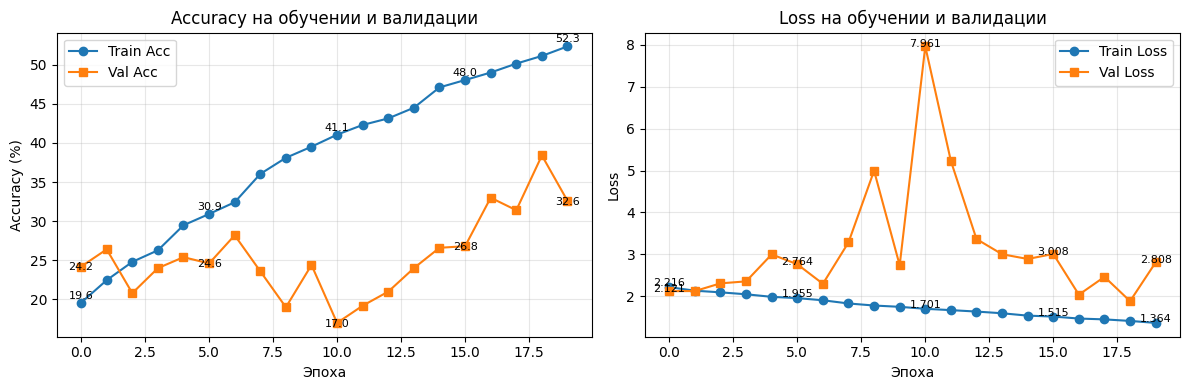

Общее количество параметров: 2,777,674

Архитектура модели:
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

'\nprint(f"Лучшая accuracy на валидации: {max(val_accs):.2f}%")\nprint(f"Финальная accuracy на валидации: {val_accs[-1]:.2f}%")\nprint(f"Accuracy на тесте: {test_acc:.2f}%")\n\nprint(f"\nЛучшая эпоха: {np.argmax(val_accs) + 1}")\nprint(f"Loss на лучшей эпохе: {val_losses[np.argmax(val_accs)]:.4f}")\n'

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy график
ax1.plot(train_accs, label='Train Acc', marker='o')
ax1.plot(val_accs, label='Val Acc', marker='s')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy на обучении и валидации')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Подписи точек на графике accuracy
for i, (train_acc, val_acc) in enumerate(zip(train_accs, val_accs)):
    if i % 5 == 0 or i == len(train_accs)-1:  # показываем каждую 5-ю и последнюю
        ax1.text(i, train_acc+0.5, f'{train_acc:.1f}', ha='center', fontsize=8)
        ax1.text(i, val_acc-0.5, f'{val_acc:.1f}', ha='center', fontsize=8)

# Loss график
ax2.plot(train_losses, label='Train Loss', marker='o')
ax2.plot(val_losses, label='Val Loss', marker='s')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Loss')
ax2.set_title('Loss на обучении и валидации')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Подписи точек на графике loss
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    if i % 5 == 0 or i == len(train_losses)-1:
        ax2.text(i, train_loss+0.02, f'{train_loss:.3f}', ha='center', fontsize=8)
        ax2.text(i, val_loss-0.02, f'{val_loss:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Информация о модели
print(f"Общее количество параметров: {total_params:,}")
print("\nАрхитектура модели:")
print(model)

'''
print(f"Лучшая accuracy на валидации: {max(val_accs):.2f}%")
print(f"Финальная accuracy на валидации: {val_accs[-1]:.2f}%")
print(f"Accuracy на тесте: {test_acc:.2f}%")

print(f"\nЛучшая эпоха: {np.argmax(val_accs) + 1}")
print(f"Loss на лучшей эпохе: {val_losses[np.argmax(val_accs)]:.4f}")
'''


Device: cpu
Вариант A: 32 → 64 → 128 → 256 каналов
Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)

Параметры модели A: 2,797,610
Параметры модели B: 2,777,674

Обучаем Model A
 1 | Train Loss: 2.2785 | Train Acc: 16.18% || Val Loss: 2.2983 | Val Acc: 17.80%
 2 | Train Loss: 2.1705 | Train Acc: 20.30% || Val Loss: 2.2416 | Val Acc: 22.00%
 3 | Train Loss: 2.1067 | Train Acc: 23.06% || Val Loss: 2.0724 | Val Acc: 26.20%
 4 | Train Loss: 2.0224 | Train Acc: 27.18% || Val Loss: 2.0080 | Val Acc: 31.20%
 5 | Train Loss: 1.9459 | Train Acc: 30.30% || Val Loss: 1.9664 | Val Acc: 32.80%
 6 | Train Loss: 1.8750 | Train Acc: 33.72% || Val Loss: 2.0227 | Val Acc: 36.40%
 7 | Train Loss: 1.8250 | Train Acc: 35.88% || Val Loss: 3.4792 | Val Acc: 20.80%
 8 | Train Loss: 1.7769 | Train Acc: 37.80% || Val Loss: 2.4581 | Val Acc: 32.00%
 9 | Train Loss: 1.7021 | Train Acc: 40.70% || Val Loss: 3.5880 | Val Acc: 28.60%
10 | Train Loss: 1.6506 | Train Acc: 42.32% || Val Loss: 2.4449 | Val Acc: 34.20%
1

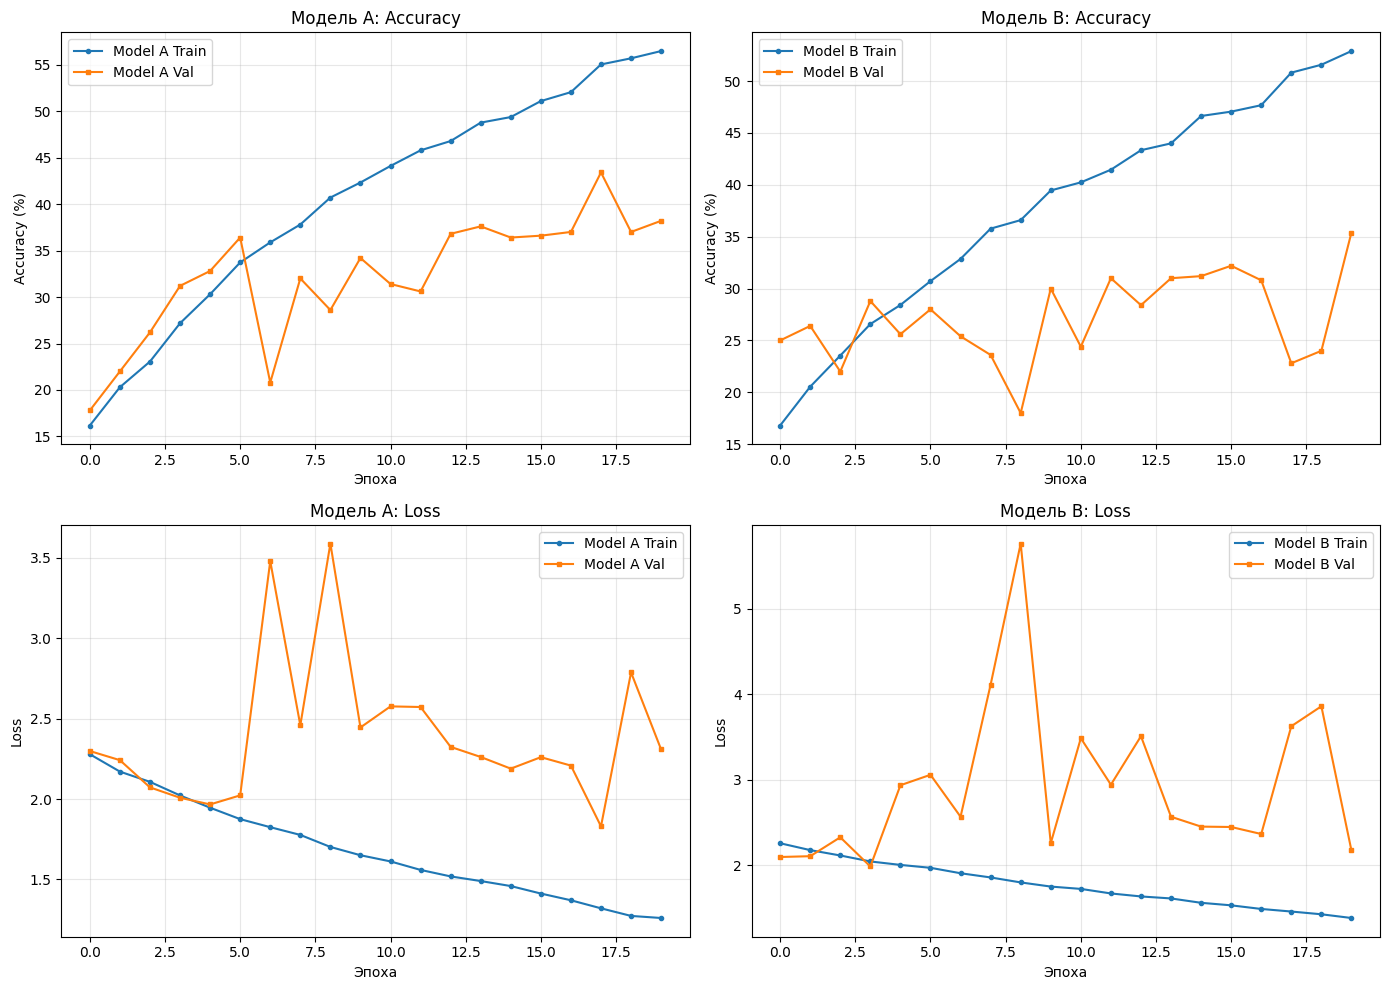

Метрика                   Model A         Model B        
-------------------------------------------------------
Параметры                 2,797,610       2,777,674      
Параметры (разница)       -               -0.7%          
Лучшая Val Acc            43.40          % 35.40          %
Финальная Val Acc         38.20          % 35.40          %


In [ ]:
# 3.1: Оптимизация количества каналов

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

print("Вариант A: 32 → 64 → 128 → 256 каналов")

class ResNet18_A(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_A, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(32, 32, blocks=2, stride=1) #32
        self.layer2 = self._make_layer(32, 64, blocks=2, stride=2) #64
        self.layer3 = self._make_layer(64, 128, blocks=2, stride=2) #128
        self.layer4 = self._make_layer(128, 256, blocks=2, stride=2) #256
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


print("Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)")

class ResNet18_B(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_B, self).__init__()
        
        # Начальный слой
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1) # 64
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2) # 128
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2) # 256
        #нет 4-го слоя
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        
        # Первый блок
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        
        # Остальные блоки
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # НЕТ layer4
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


def train_model_simple(model, train_loader, val_loader, model_name="модель"):
    print(f"\nОбучаем {model_name}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 20
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss_avg)
        train_accs.append(train_acc)
        
        # Валидация
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss_avg)
        val_accs.append(val_acc)
        
        # Вывод для каждой эпохи
        print(f"{epoch+1:2d} | Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc:.2f}% || Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:.2f}%")
    
    return model, train_losses, train_accs, val_losses, val_accs



# Создаем модели
model_A = ResNet18_A()
model_B = ResNet18_B()

params_A = sum(p.numel() for p in model_A.parameters())
params_B = sum(p.numel() for p in model_B.parameters())

print(f"\nПараметры модели A: {params_A:,}")
print(f"Параметры модели B: {params_B:,}")


model_A, train_loss_A, train_acc_A, val_loss_A, val_acc_A = train_model_simple(
    model_A, train_loader, val_loader, "Model A"
)
model_B, train_loss_B, train_acc_B, val_loss_B, val_acc_B = train_model_simple(
    model_B, train_loader, val_loader, "Model B"
)



fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График Accuracy
axes[0, 0].plot(train_acc_A, label='Model A Train', marker='o', markersize=3)
axes[0, 0].plot(val_acc_A, label='Model A Val', marker='s', markersize=3)
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_title('Модель A: Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(train_acc_B, label='Model B Train', marker='o', markersize=3)
axes[0, 1].plot(val_acc_B, label='Model B Val', marker='s', markersize=3)
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Модель B: Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# График Loss
axes[1, 0].plot(train_loss_A, label='Model A Train', marker='o', markersize=3)
axes[1, 0].plot(val_loss_A, label='Model A Val', marker='s', markersize=3)
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Модель A: Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(train_loss_B, label='Model B Train', marker='o', markersize=3)
axes[1, 1].plot(val_loss_B, label='Model B Val', marker='s', markersize=3)
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Модель B: Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




print(f"{'Метрика':<25} {'Model A':<15} {'Model B':<15}")
print("-"*55)
print(f"{'Параметры':<25} {params_A:<15,} {params_B:<15,}")
print(f"{'Параметры (разница)':<25} {'-':<15} {f'{(params_B-params_A)/params_A*100:+.1f}%':<15}")
print(f"{'Лучшая Val Acc':<25} {max(val_acc_A):<15.2f}% {max(val_acc_B):<15.2f}%")
print(f"{'Финальная Val Acc':<25} {val_acc_A[-1]:<15.2f}% {val_acc_B[-1]:<15.2f}%")

Модель B использовала меньше параметров, что может быть важно для некоторых задач, однако модель А (32 → 64 → 128 → 256 каналов) показала большую точность на валидации, и потому более предпочтительна для нас. Далее используем модель А

Device: cpu
Модель Model A (1,1,1,1)
Блоки: [1, 1, 1, 1] (всего блоков: 4)

Параметры: 1,228,970

Обучаем Model A (1,1,1,1)
Эпоха  1 | Train Loss: 2.2312 | Train Acc: 18.89% || Val Loss: 2.1285 | Val Acc: 20.80%
Эпоха  2 | Train Loss: 2.1469 | Train Acc: 21.18% || Val Loss: 2.1042 | Val Acc: 23.40%
Эпоха  3 | Train Loss: 2.0963 | Train Acc: 24.84% || Val Loss: 2.1040 | Val Acc: 26.00%
Эпоха  4 | Train Loss: 2.0438 | Train Acc: 25.67% || Val Loss: 2.5618 | Val Acc: 23.60%
Эпоха  5 | Train Loss: 2.0026 | Train Acc: 28.40% || Val Loss: 2.5953 | Val Acc: 26.00%
Эпоха  6 | Train Loss: 1.9383 | Train Acc: 30.33% || Val Loss: 2.3864 | Val Acc: 28.80%
Эпоха  7 | Train Loss: 1.8718 | Train Acc: 33.87% || Val Loss: 2.3684 | Val Acc: 27.60%
Эпоха  8 | Train Loss: 1.8272 | Train Acc: 35.16% || Val Loss: 5.7962 | Val Acc: 18.20%
Эпоха  9 | Train Loss: 1.7963 | Train Acc: 36.53% || Val Loss: 2.2020 | Val Acc: 32.80%
Эпоха 10 | Train Loss: 1.7352 | Train Acc: 39.44% || Val Loss: 4.0589 | Val Acc: 24.

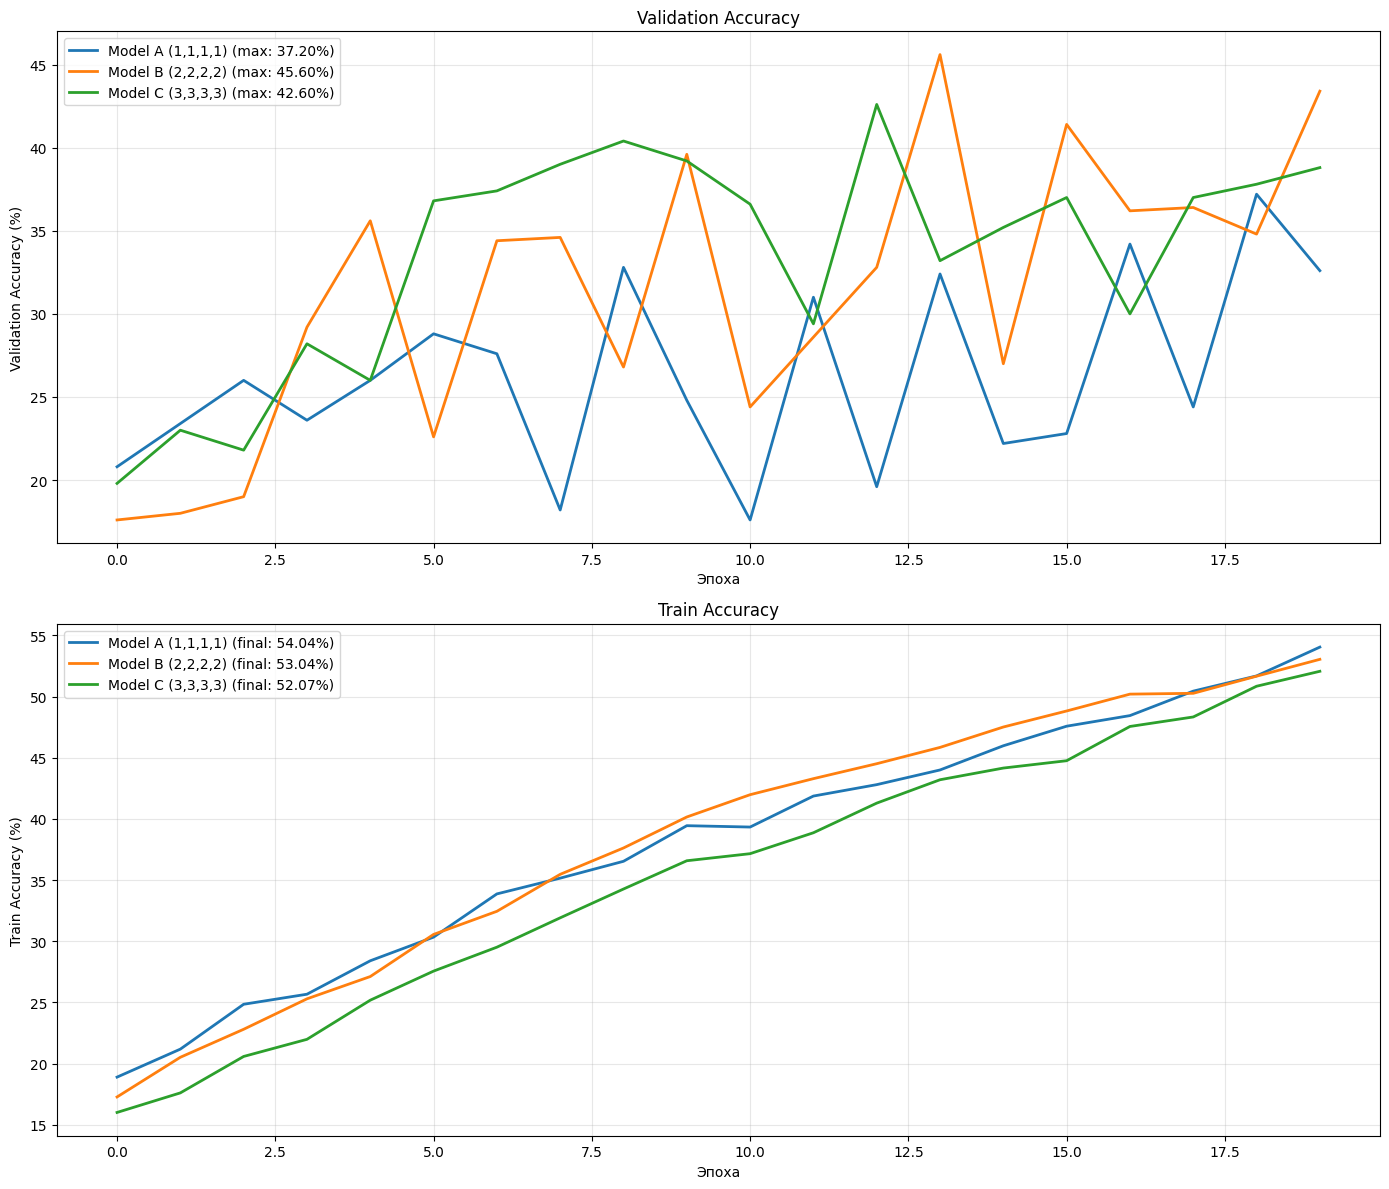


Модель               Блоки           Параметры       Лучшая Val Acc       Эпоха      Финальная Val Acc   
----------------------------------------------------------------------------------------------------
Model A (1,1,1,1)    [1, 1, 1, 1]    1,228,970       37.20               % 19         32.60               %
Model B (2,2,2,2)    [2, 2, 2, 2]    2,797,610       45.60               % 14         43.40               %
Model C (3,3,3,3)    [3, 3, 3, 3]    4,366,250       42.60               % 13         38.80               %

Лучшая модель: Model B (2,2,2,2)
Лучшая точность: 45.60%


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Проверка GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# модель с настраеваемым количество блоков
class ResNetVariableDepth(nn.Module):
    def __init__(self, num_classes=10, blocks_per_layer=[2, 2, 2, 2]):
        super(ResNetVariableDepth, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        

        self.layer1 = self._make_layer(32, 32, num_blocks=blocks_per_layer[0], stride=1) # 32
        self.layer2 = self._make_layer(32, 64, num_blocks=blocks_per_layer[1], stride=2) # 64
        self.layer3 = self._make_layer(64, 128, num_blocks=blocks_per_layer[2], stride=2) #128
        self.layer4 = self._make_layer(128, 256, num_blocks=blocks_per_layer[3], stride=2) #256
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


def train_model_with_blocks(model, train_loader, val_loader, model_name="модель", num_epochs=20):
    print(f"\nОбучаем {model_name}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss_avg)
        train_accs.append(train_acc)
        
        # Валидация
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss_avg)
        val_accs.append(val_acc)
        
        # Вывод
        print(f"Эпоха {epoch+1:2d} | Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc:5.2f}% || Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:5.2f}%")
    
    return train_losses, train_accs, val_losses, val_accs



# Создаем модели с разным количеством блоков
models_config = {
    "Model A (1,1,1,1)": [1, 1, 1, 1],
    "Model B (2,2,2,2)": [2, 2, 2, 2],
    "Model C (3,3,3,3)": [3, 3, 3, 3]
}

results = {}
params_count = {}

# Обучаем каждую модель
for model_name, blocks in models_config.items():
    print(f"Модель {model_name}")
    print(f"Блоки: {blocks} (всего блоков: {sum(blocks)})")
    print()
    
    # Создаем модель
    model = ResNetVariableDepth(num_classes=10, blocks_per_layer=blocks)
    params_count[model_name] = sum(p.numel() for p in model.parameters())
    print(f"Параметры: {params_count[model_name]:,}")
    
    # Обучаем
    train_loss, train_acc, val_loss, val_acc = train_model_with_blocks(model, train_loader, val_loader, model_name=model_name, num_epochs=20)
    
    results[model_name] = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }



#Графики
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Accuracy на валидации (все модели на одном графике)
ax1 = axes[0]
for model_name in models_config.keys():
    ax1.plot(results[model_name]['val_acc'], 
            label=f"{model_name} (max: {max(results[model_name]['val_acc']):.2f}%)",
            linewidth=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Validation Accuracy (%)')
ax1.set_title('Validation Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Train Accuracy (все модели на одном графике)
ax2 = axes[1]
for model_name in models_config.keys():
    ax2.plot(results[model_name]['train_acc'], 
            label=f"{model_name} (final: {results[model_name]['train_acc'][-1]:.2f}%)",
            linewidth=2)
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Train Accuracy (%)')
ax2.set_title('Train Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


print(f"\n{'Модель':<20} {'Блоки':<15} {'Параметры':<15} {'Лучшая Val Acc':<20} {'Эпоха':<10} {'Финальная Val Acc':<20}")
print("-"*100)

best_model = None
best_acc = 0

for model_name in models_config.keys():
    blocks = models_config[model_name]
    total_blocks = sum(blocks)
    params = params_count[model_name]
    best_val_acc = max(results[model_name]['val_acc'])
    best_epoch = results[model_name]['val_acc'].index(best_val_acc) + 1
    final_val_acc = results[model_name]['val_acc'][-1]
    
    print(f"{model_name:<20} {str(blocks):<15} {params:<15,} {best_val_acc:<20.2f}% {best_epoch:<10} {final_val_acc:<20.2f}%")
    
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model = model_name


print(f"\nЛучшая модель: {best_model}")
print(f"Лучшая точность: {best_acc:.2f}%")

3.2 выводы:
С увеличением количества блоков увеличивается и количество параметров. Модель B с 2.8M показала показала лучшую validation accuracy, опередив модели и с большим, и с меньшим количеством блоков (и параметров). Скорость сходимости (скорость достижения лучшего результата) оказалась выше у модели С, с 12 блоками, которая достигла лучшей validation accuracy за 13 эпох. 

Увеличение глубины с 4 до 8 блоков дает значительный прирост производительности (+8.4%). Дальнейшее увеличение до 12 блоков приводит к снижению accuracy (-3.0%) относительно модели В. Исходя из результатов, оптимальная глубина модели для нашей задачи — 8 блоков.

У наиболее глубокой модели С есть признаки переобучения, например, значительный разрыв train acc и val acc на последних эпохах, но ещё больший разрыв между train acc и val acc есть у модели А, самой неглубокой. Это неожиданно, потому что обычно к переобучению склонны глубокие модели. Возможно, результат изменится с увеличением количества эпох или изменения гиперпараметров. 

Device: cpu
Модель с активацией: ReLU
Эпоха  1 | Train Loss: 2.3409 | Train Acc: 12.58% | Val Loss: 2.2957 | Val Acc: 20.80%
Эпоха  2 | Train Loss: 2.2324 | Train Acc: 16.56% | Val Loss: 2.5185 | Val Acc: 19.20%
Эпоха  3 | Train Loss: 2.2173 | Train Acc: 17.24% | Val Loss: 2.3248 | Val Acc: 22.20%
Эпоха  4 | Train Loss: 2.1785 | Train Acc: 19.80% | Val Loss: 2.1835 | Val Acc: 26.20%
Эпоха  5 | Train Loss: 2.1577 | Train Acc: 20.40% | Val Loss: 2.1480 | Val Acc: 23.80%
Эпоха  6 | Train Loss: 2.1077 | Train Acc: 22.73% | Val Loss: 2.1020 | Val Acc: 28.40%
Эпоха  7 | Train Loss: 2.0559 | Train Acc: 26.22% | Val Loss: 1.9743 | Val Acc: 34.60%
Эпоха  8 | Train Loss: 1.9915 | Train Acc: 28.78% | Val Loss: 1.8580 | Val Acc: 36.40%
Эпоха  9 | Train Loss: 1.9399 | Train Acc: 30.80% | Val Loss: 2.0597 | Val Acc: 36.20%
Эпоха 10 | Train Loss: 1.8781 | Train Acc: 34.02% | Val Loss: 1.9671 | Val Acc: 37.00%
Эпоха 11 | Train Loss: 1.8349 | Train Acc: 35.00% | Val Loss: 1.8689 | Val Acc: 36.60%
Эпоха

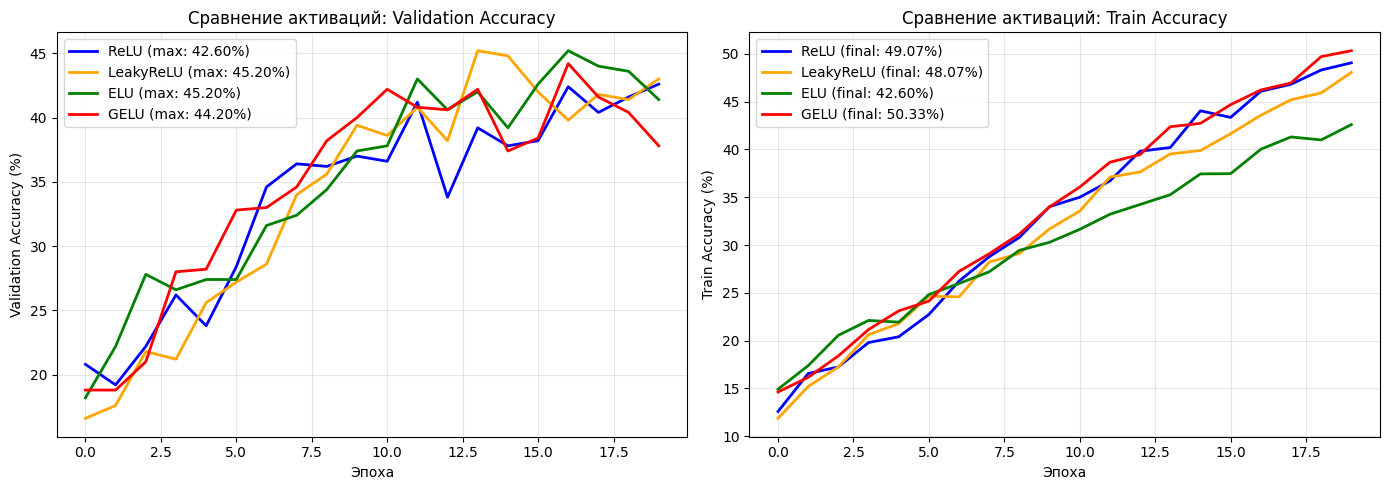


Активация       Параметры    Лучшая Val Acc     Эпоха    Финальная Val Acc  Скорость сходимости 
----------------------------------------------------------------------------------------------------
ReLU            2,797,610    42.60             % 20       42.60             %
LeakyReLU       2,797,610    45.20             % 14       43.00             %
ELU             2,797,610    45.20             % 17       41.40             %
GELU            2,797,610    44.20             % 17       37.80             %


In [13]:
#3.3 Эксперименты с функциями активации

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Проверка GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


class BasicBlockWithActivation(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation='relu'):
        super(BasicBlockWithActivation, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Выбираем активацию
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.1, inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            self.activation = nn.ReLU(inplace=True)
        
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.activation(out)
        
        return out

class ResNetWithActivation(nn.Module):
    def __init__(self, num_classes=10, activation='relu'):
        super(ResNetWithActivation, self).__init__()
        
        # [2, 2, 2, 2] блоков с каналами 32→64→128→256
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Активации
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.1, inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            self.activation = nn.ReLU(inplace=True)
        
        # Слои
        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1, activation=activation)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2, activation=activation)
        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2, activation=activation)
        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2, activation=activation)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride, activation):
        layers = []
        
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(BasicBlockWithActivation(in_channels, out_channels, stride, downsample, activation))
        
        for _ in range(1, num_blocks):
            layers.append(BasicBlockWithActivation(out_channels, out_channels, 1, None, activation))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


# Обучение
def train_model_activation(model, train_loader, val_loader, model_name="Модель", num_epochs=20):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss_avg)
        train_accs.append(train_acc)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss_avg)
        val_accs.append(val_acc)
        
        """
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Эпоха {epoch+1:2d} | Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc:5.2f}% | Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:5.2f}%")
        """
        
        print(f"Эпоха {epoch+1:2d} | Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc:5.2f}% | Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:5.2f}%")
    
    return train_accs, val_accs, train_losses, val_losses


activations = {
    'ReLU': 'relu',
    'LeakyReLU': 'leakyrelu',
    'ELU': 'elu',
    'GELU': 'gelu'}

results = {}
params_count = {}

# Обучаем каждую модель
for act_name, act_type in activations.items():
    print(f"Модель с активацией: {act_name}")
    
    # Создаем модель
    model = ResNetWithActivation(num_classes=10, activation=act_type)
    params_count[act_name] = sum(p.numel() for p in model.parameters())
    
    # Обучаем
    train_acc, val_acc, train_loss, val_loss = train_model_activation(model, train_loader, val_loader, model_name=act_name, num_epochs=20 )
    
    results[act_name] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_loss': train_loss,
        'val_loss': val_loss }



# Графики
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['blue', 'orange', 'green', 'red']

ax1 = axes[0] 
for i, (act_name, color) in enumerate(zip(activations.keys(), colors)):
    ax1.plot(results[act_name]['val_acc'], 
            label=f"{act_name} (max: {max(results[act_name]['val_acc']):.2f}%)",
            color=color,
            linewidth=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Validation Accuracy (%)')
ax1.set_title('Сравнение активаций: Validation Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1] 
for i, (act_name, color) in enumerate(zip(activations.keys(), colors)):
    ax2.plot(results[act_name]['train_acc'], 
            label=f"{act_name} (final: {results[act_name]['train_acc'][-1]:.2f}%)",
            color=color,
            linewidth=2)
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Train Accuracy (%)')
ax2.set_title('Сравнение активаций: Train Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'Активация':<15} {'Параметры':<12} {'Лучшая Val Acc':<18} {'Эпоха':<8} {'Финальная Val Acc':<18} {'Скорость сходимости':<20}")
print("-"*100)

best_val_acc = max(max(results[act]['val_acc']) for act in activations.keys())

for act_name in activations.keys():
    params = params_count[act_name]
    best_acc = max(results[act_name]['val_acc'])
    best_epoch = results[act_name]['val_acc'].index(best_acc) + 1
    final_acc = results[act_name]['val_acc'][-1]
    
    if best_acc == best_val_acc:
        print(f"{'' + act_name:<15} {params:<12,} {best_acc:<18.2f}% {best_epoch:<8} {final_acc:<18.2f}%")
    else:
        print(f"{act_name:<15} {params:<12,} {best_acc:<18.2f}% {best_epoch:<8} {final_acc:<18.2f}%")


3.3 Выводы:

Модель с LeakyReLU продемонстрировала лучший результат, показав самую высокую итоговую точность на валидации. Хотя в начале обучения её сходимость была медленнее, чем у baseline с ReLU, после середины процесса она не только догнала, но и стабильно превзошла другие активации.
ELU обучалась медленнее всех, но к концу обучения вышла на сопоставимый с ReLU и LeakyReLU уровень, что позволяет считать её перспективным, хотя и более медленным вариантом.
GELU быстро обучалась изначально, но затем её точность на валидации стала падать.

Исходя из результатов, LeakyReLU является лучшим выбором, потому что показало лучшую точность и достаточно стабильный процесс обучения.

In [5]:
# 4.1: Создание финальной модели

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


class FinalModel(nn.Module):
    def __init__(self, num_classes=10):
        super(FinalModel, self).__init__()
        
        # 32→64→128→256 каналов
        # [2, 2, 2, 2] блоков
        # LeakyReLU активация
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.activation = nn.LeakyReLU(0.1, inplace=True)
        
        # Слои
        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(self._make_block(in_channels, out_channels, stride, downsample))
        
        for _ in range(1, num_blocks):
            layers.append(self._make_block(out_channels, out_channels, 1, None))
            
        return nn.Sequential(*layers)
    
    def _make_block(self, in_channels, out_channels, stride, downsample):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

#Обучение
model = FinalModel(num_classes=10).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Параметры модели: {total_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 30

train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_acc = 0
best_model_weights = None
best_epoch = 0

for epoch in range(num_epochs):

    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_loss_avg = train_loss / len(train_loader)
    train_acc = 100. * train_correct / train_total
    train_losses.append(train_loss_avg)
    train_accs.append(train_acc)
    
    # Val
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss_avg = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss_avg)
    val_accs.append(val_acc)
    
    # Вывод
    print(f"Эпоха {epoch+1:2d} | Train Loss: {train_loss_avg:.4f} | Train Acc: {train_acc:5.2f}% | Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:5.2f}%")
    
    # Сохраняем лучшую модель
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch + 1
        best_model_weights = model.state_dict().copy()
        
        # Сохраняем лучшую модель
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': best_model_weights,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'val_loss': val_loss_avg,
            'train_loss': train_loss_avg,
            'config': {
                'channels': [32, 64, 128, 256],
                'blocks': [2, 2, 2, 2],
                'activation': 'LeakyReLU',
                'num_classes': 10,
                'total_params': total_params
            }
        }, 'best_model.pth')
        

print(f"\nЛучшая точность: {best_acc:.2f}% (эпоха {best_epoch})")
print(f"Финальная точность: {val_accs[-1]:.2f}%")

Device: cpu
Параметры модели: 2,753,706
Эпоха  1 | Train Loss: 2.3549 | Train Acc: 11.44% | Val Loss: 2.3003 | Val Acc: 10.40%
Эпоха  2 | Train Loss: 2.2691 | Train Acc: 13.13% | Val Loss: 2.2362 | Val Acc: 15.60%
Эпоха  3 | Train Loss: 2.2016 | Train Acc: 16.62% | Val Loss: 2.1642 | Val Acc: 17.20%
Эпоха  4 | Train Loss: 2.1892 | Train Acc: 17.89% | Val Loss: 2.1497 | Val Acc: 16.60%
Эпоха  5 | Train Loss: 2.1759 | Train Acc: 17.38% | Val Loss: 2.1308 | Val Acc: 18.20%
Эпоха  6 | Train Loss: 2.1711 | Train Acc: 18.24% | Val Loss: 2.0814 | Val Acc: 22.00%
Эпоха  7 | Train Loss: 2.1691 | Train Acc: 17.73% | Val Loss: 2.0518 | Val Acc: 24.40%
Эпоха  8 | Train Loss: 2.1348 | Train Acc: 20.18% | Val Loss: 2.0276 | Val Acc: 23.60%
Эпоха  9 | Train Loss: 2.1237 | Train Acc: 20.82% | Val Loss: 2.0107 | Val Acc: 30.00%
Эпоха 10 | Train Loss: 2.0908 | Train Acc: 23.20% | Val Loss: 1.9657 | Val Acc: 26.80%
Эпоха 11 | Train Loss: 2.0786 | Train Acc: 24.04% | Val Loss: 1.9342 | Val Acc: 29.80%
Эпо

Device: cpu

Accuracy: 41.60%
Класс           Precision    Recall       F1-score     Support   
--------------------------------------------------
n02279972       0.5667       0.6800       0.6182       50        
n01774384       0.5455       0.6000       0.5714       50        
n01945685       0.3068       0.5400       0.3913       50        
n02190166       0.5000       0.1800       0.2647       50        
n01774750       0.4872       0.3800       0.4270       50        
n01784675       0.2941       0.5000       0.3704       50        
n01944390       0.3125       0.1000       0.1515       50        
n02165456       0.5106       0.4800       0.4948       50        
n02206856       0.3585       0.3800       0.3689       50        
n02226429       0.4103       0.3200       0.3596       50        

Precision: 0.4292
Recall: 0.4160
F1-score: 0.4018

Confusion Matrix:


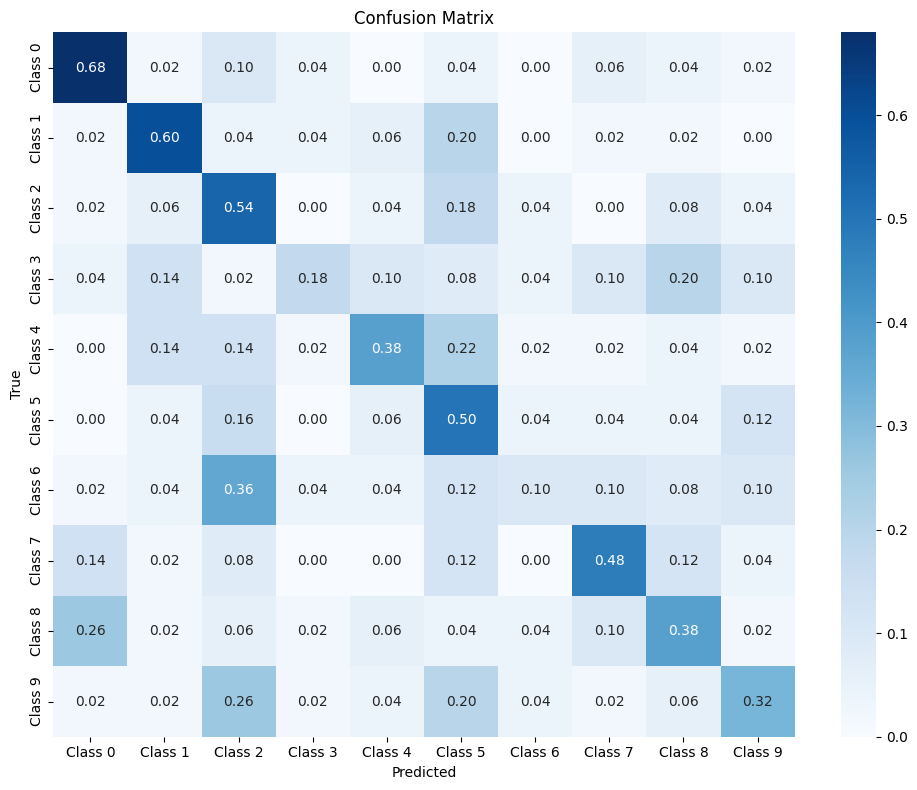

In [9]:
# 4.2: Тестирование на test set

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = FinalModel(num_classes=10).to(device)

# Загружаем модель
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        
        if labels[0] != -1:
            all_labels.extend(labels.numpy())
        
        all_probs.extend(probs.cpu().numpy())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)

print(f"{'Класс':<15} {'Precision':<12} {'Recall':<12} {'F1-score':<12} {'Support':<10}")
print("-"*50)

for i in range(len(precision)):
    class_name = selected[i] if i < len(selected) else f"Class {i}"
    print(f"{class_name[:12]:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average='macro'
)

print()
print(f"Precision: {precision_avg:.4f}")
print(f"Recall: {recall_avg:.4f}")
print(f"F1-score: {f1_avg:.4f}")


print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(10)],
            yticklabels=[f'Class {i}' for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()



Device: cpu


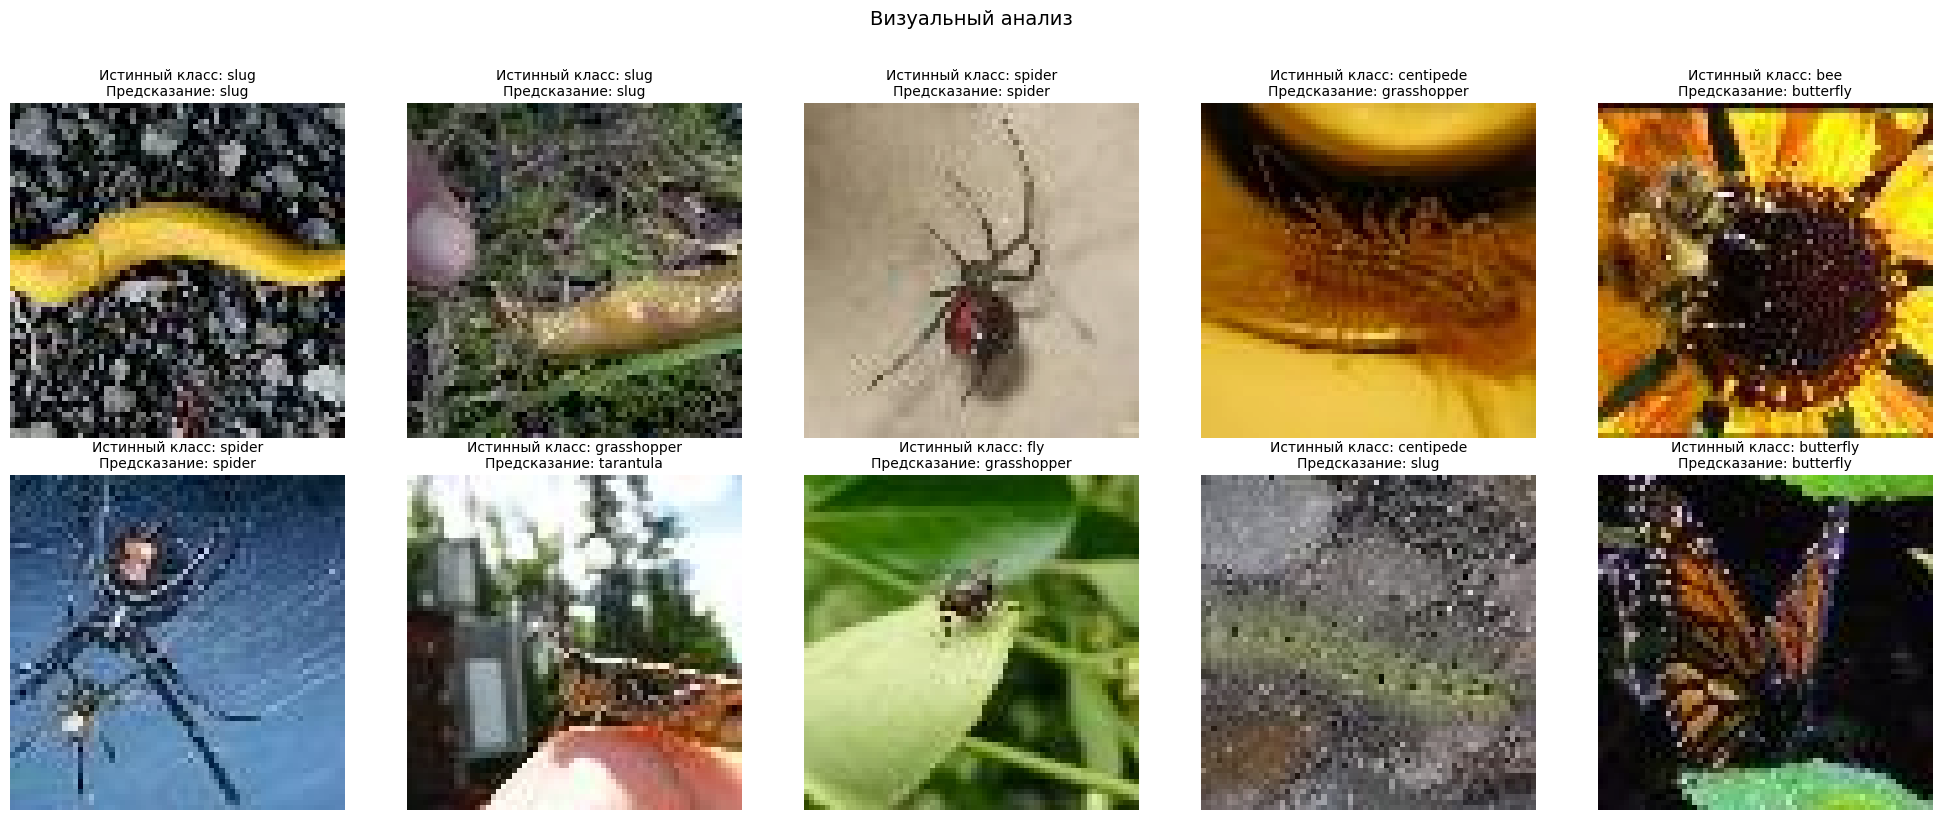

In [ ]:
# 4.3: Визуальный анализ

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

class FinalModel(nn.Module):
    def __init__(self, num_classes=10):
        super(FinalModel, self).__init__()
        
        # 32→64→128→256 каналов
        # [2, 2, 2, 2] блоков
        # LeakyReLU активация
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.activation = nn.LeakyReLU(0.1, inplace=True)
        
        # Слои
        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(self._make_block(in_channels, out_channels, stride, downsample))
        
        for _ in range(1, num_blocks):
            layers.append(self._make_block(out_channels, out_channels, 1, None))
            
        return nn.Sequential(*layers)
    
    def _make_block(self, in_channels, out_channels, stride, downsample):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

model = FinalModel(num_classes=10).to(device)

checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


# Имена классов (я люблю насекомышей)
class_names = {
    'n02279972': 'butterfly',
    'n01774384': 'spider',
    'n01945685': 'slug',
    'n02190166': 'fly',
    'n01774750': 'tarantula',
    'n01784675': 'centipede',
    'n01944390': 'snail',
    'n02165456': 'ladybug',
    'n02206856': 'bee',
    'n02226429': 'grasshopper'
}


test_dataset = TinyImageNetDataset(root, split='val', transform=val_transform, selected_classes=selected)

N = 10
random_indices = random.sample(range(len(test_dataset)), N)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    image, true_label = test_dataset[idx]
    
    # Делаем предсказание
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
    
    image_np = image.numpy().transpose(1, 2, 0)
    
    # Денормализация
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    is_correct = (true_label == predicted_label)
    
    axes[i].imshow(image_np)
    axes[i].axis('off')
    
    # имена классов
    if true_label < len(selected) and predicted_label < len(selected):
        true_class = class_names[selected[true_label]]
        pred_class = class_names[selected[predicted_label]]
    else:
        true_class = f"Class {true_label}"
        pred_class = f"Class {predicted_label}"
    
    
    title = f"Истинный класс: {true_class}\nПредсказание: {pred_class}"
    
    axes[i].set_title(title, color='black', fontsize=10)
    
plt.suptitle('Визуальный анализ', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

| Этап | Конфигурация | Параметры | Val Accuracy | Train Accuracy |
|------|--------------|-----------|--------------|----------------|
| Baseline | Ваша базовая модель | 2.8M | 33.00% | 49.00% |
| 3.1-A | 32→64→128→256 | 2.8M | 43.40% | 55.02% |
| 3.1-B | 64→128→256 | 2.8M | 35.40% | 52.90% |
| 3.2-A | [1,1,1,1] блоков | 1.2M | 37.20% | 51.69% |
| 3.2-B | [2,2,2,2] блоков | 2.8M | 45.60% | 45.84% |
| 3.2-C | [3,3,3,3] блоков | 4.4M | 42.60% | 41.29% |
| 3.3-A | ReLU | 2.8M | 42.60% | 49.07% |
| 3.3-B | LeakyReLU | 2.8M | 45.20% | 39.53% |
| 3.3-C | ELU | 2.8M | 45.20% | 40.02% |
| 3.3-D | GELU | 2.8M | 44.20% | 46.22% |
| Final | Лучшая конфигурация | 2.8M | 41.20% | 31.98% |

Лучший результат: конфигурация 3.2-B с [2,2,2,2] блоками показала наивысшую Val Accuracy - 45.60%.

Это аномальный результат, так как мы на каждом этапе брали лучшую конфигурацию модели, постепенно улучшали её — значит, и результат должен был улучшаться. Причину таких результатов можно объяснить тем, что batch size в датасетах менялся на протяжении выполнения работы. Первые несколько моделей запускались с batch size = 64, потом он опустился до 16, а затем до 4 для ускорения работы. Предположение о том, что это не окажет значительного влияния на результаты, похоже, оказалось неверным. Для получения более точных результатов стоит провести исследования улучшения конфигурации модели при постоянном размере batch size, а также проверить влияние размеров batch size на точность модели.

Признаки переобучения: в целом разница между Train и Val Accuracy умеренная, но у Baseline и 3.1-A наблюдается значительный разрыв (16% и 11.6% соответственно), что указывает на переобучение. Наиболее сбалансированные результаты у 3.2-B (разница всего 0.24%).